In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../source/")
from evolutionary import *
from functools import partial
import scipy

# One-Max Function

It's a very simple (toy) example of an optimization problem for binary vector: the value to optimize is the number of 1s in the vector

$fitness(x) = \sum_{i=1}^n x_i$

In [2]:
def one_max(b: BitVectorCandidate):
    return np.sum(b.candidate)

In [3]:
max_value = 100

genalgo_one_max = GeneticAlgorithm(100,
                                   BitVectorCandidate,
                                   partial(tournament_selection, tournament_size=5),
                                   one_max,
                                   elitism=True,
                                   **{"p": 0.05, "size": max_value})

(0.0, 100.0)

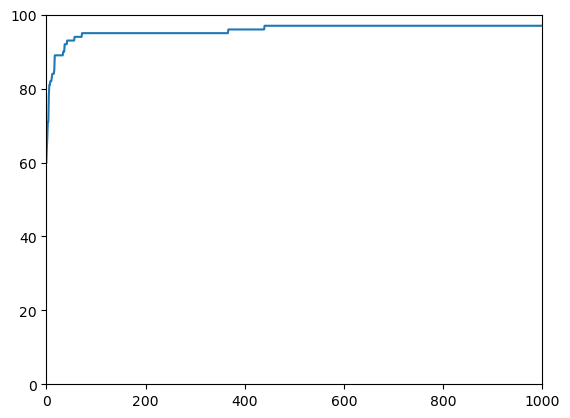

In [4]:
iters = 1000

genalgo_one_max.fit(iters, keep_history=True)
history = genalgo_one_max.fitness_h

plt.plot(history)
plt.xlim(0,iters)
plt.ylim(0,max_value)


# Trap

It is a tricky optimization problem: the value is the number of 1s -> unless you have the all 0s or the all 1s vectors:

        If all 0s -> the fitness value is n (maximum)
        
        If all 1s -> the fitness value is 0 (minimum)
        
$fitness(x) = \begin{cases}
1 & \forall i, x_i = 0\\
0 & \forall i, x_i = 1\\
\sum_i x_i & otherwise
\end{cases}$

In [5]:
def trap(b: BitVectorCandidate):
    v = np.sum(b.candidate)
    if v == 0:
        return b.size
    elif v == b.size:
        return 0
    else:
        return v

In [6]:
max_value = 100

genalgo_trap = GeneticAlgorithm(100,
                                BitVectorCandidate,
                                partial(tournament_selection, tournament_size=5),
                                trap,
                                elitism=True,
                                **{"p": 0.05, "size": max_value})

(0.0, 100.0)

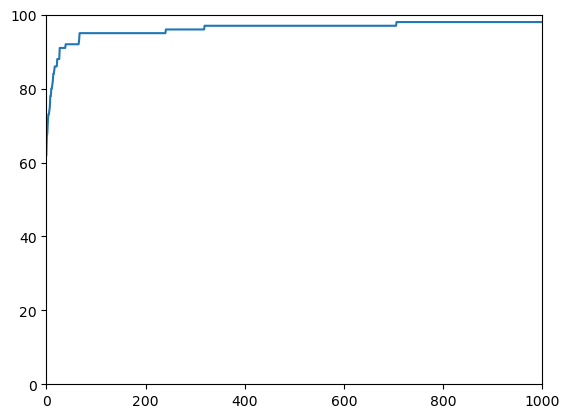

In [7]:
iters = 1000

genalgo_trap.fit(iters, keep_history=True)
history = genalgo_trap.fitness_h

plt.plot(history)
plt.xlim(0,iters)
plt.ylim(0,max_value)


# Linear

It is the real-valued version of one-max: the function to optimize is to maximize a linear function,
specified by a given vector

$f_a(x) = \sum_i a_i x_i$

In [2]:
def linear(v: FloatVectorCandidate, a: np.ndarray):
    return np.sum(v.candidate * a)

In [16]:
max_value = 10

a = np.random.rand(max_value)
print(np.sum(a))
genalgo_linear = GeneticAlgorithm(100,
                                  FloatVectorCandidate,
                                  partial(tournament_selection, tournament_size=5),
                                  partial(linear, a=a),
                                  elitism=True,
                                  **{"distribution": scipy.stats.uniform(loc=-0.05, scale=0.1),
                                     "size": max_value,
                                     "lower": 0,
                                     "upper": 1})

5.280515352930118


(0.0, 5.477076119025309)

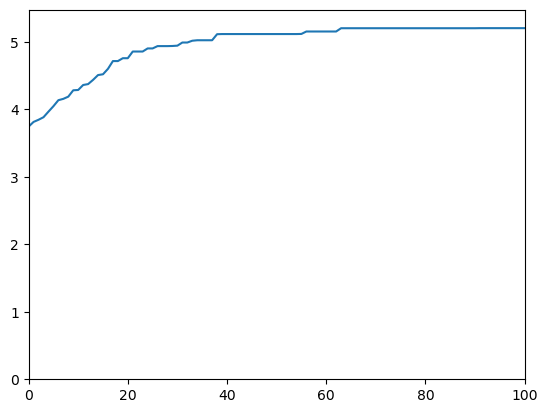

In [25]:
iters = 100

genalgo_linear.fit(iters, keep_history=True)
history = genalgo_linear.fitness_h
plt.plot(history)
plt.xlim(0,iters)
plt.ylim(0,np.sum(a))

# Rastrigin

It's a benchmark optimization problem: it is very difficult because it has a huge number of local optima

In [2]:
def rastrigin(v: FloatVectorCandidate):
    return -(10*v.size + np.sum(v.candidate*v.candidate - 10*np.cos(2*np.pi*v.candidate)))

In [3]:
max_value = 10

genalgo_rastrigin = GeneticAlgorithm(100,
                                  FloatVectorCandidate,
                                  partial(tournament_selection, tournament_size=5),
                                  rastrigin,
                                  elitism=True,
                                  **{"distribution": scipy.stats.uniform(loc=-0.05, scale=0.1),
                                     "size": max_value,
                                     "lower": -5.12,
                                     "upper": 5.12})

(0.0, 100.0)

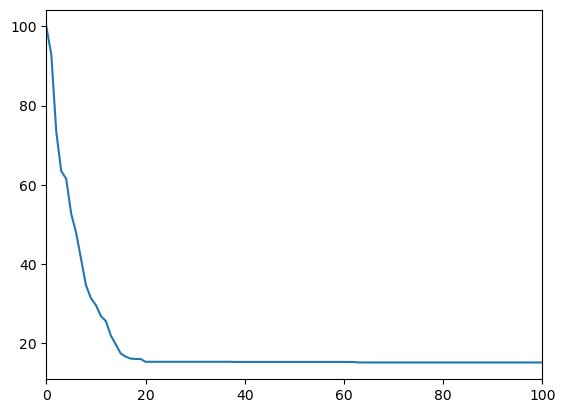

In [6]:
iters = 100

genalgo_rastrigin.fit(iters, keep_history=True)
history = genalgo_rastrigin.fitness_h
plt.plot(history*-1)
plt.xlim(0,iters)
#plt.ylim(0,np.sum(a))

# Least-Squares Linear Regression

The objective is, given a matrix of data $X$ and observations $y$ generated by $X \cdot w + \epsilon=y$ (with $w$ unknown and $\epsilon \sim N(0,1)$ being random noise), to retrieve
the unknown vector $w$. We encode this by defining a loss function by which we measure the fitness of a candidate $a$:
    
$ fitness(a) = -\sum_i (y - X[i,:] \cdot a)^2 $

In [26]:
def linear_regression(v: FloatVectorCandidate, X, y):
    return -np.sum((y - X.dot(v.candidate))*(y - X.dot(v.candidate)))

In [34]:
features = 5
instances = 30

X = scipy.stats.norm.rvs(size=(instances, features), loc=0, scale=1)
w = scipy.stats.uniform.rvs(size=features, loc=-1, scale=2)
y = X.dot(w) + scipy.stats.norm.rvs(size=(instances), loc=0, scale=1)
w

array([ 0.30920268, -0.47999715, -0.60738011,  0.99881769,  0.20402905])

In [35]:
genalgo_lr = GeneticAlgorithm(100,
                                  FloatVectorCandidate,
                                  partial(tournament_selection, tournament_size=5),
                                  partial(linear_regression, X=X, y=y),
                                  elitism=True,
                                  **{"distribution": scipy.stats.uniform(loc=-0.05, scale=0.1),
                                     "size": features,
                                     "lower": -1,
                                     "upper": 1})

(0.0, 1000.0)

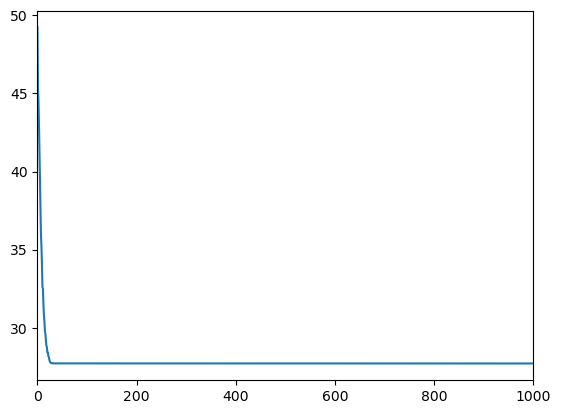

In [36]:
iters = 1000

genalgo_lr.fit(iters, keep_history=True)
history = genalgo_lr.fitness_h
plt.plot(history*-1)
plt.xlim(0,iters)
#plt.ylim(0,np.sum(a))

In [38]:
print(w)
print(genalgo_lr.best.candidate)
print(np.linalg.norm(w - genalgo_lr.best.candidate))

[ 0.30920268 -0.47999715 -0.60738011  0.99881769  0.20402905]
[ 0.31507586 -0.43285516 -0.59947372  0.55890667 -0.05607952]
0.5133201146491881
